# 왜 안 도ㅑㅐ

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

boston = pd.read_csv('./boston-housing.csv', header=None, sep=r'\s+')
boston.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
display(boston.head())  # print 말고 dataframe 제대로 보고싶으면 사용하는 법.
# print(boston.head())  # 얘는 못생김.

# 변수 설명 딕셔너리
feature_descriptions = {
    'CRIM': '지역별 1인당 범죄율',
    'ZN': '25,000 sq.ft. 이상 주거지역 비율',
    'INDUS': '비소매업 지역 비율', 
    'CHAS': '찰스강 인접 여부 (1: 인접, 0: 비인접)',
    'NOX': '일산화질소 농도 (ppm)',
    'RM': '주택당 평균 방 개수',
    'AGE': '1940년 이전 건축 주택 비율',
    'DIS': '보스턴 고용센터까지 가중거리',
    'RAD': '방사형 고속도로 접근성 지수',
    'TAX': '재산세율',
    'PTRATIO': '학생-교사 비율',
    'B': '흑인 거주 비율 관련 지수',
    'LSTAT': '하위계층 비율',
    'PRICE': '주택 중간값 (단위: $1000)'
}

for var, desc in feature_descriptions.items():
    print(f"  {var}: {desc}")

print(f"\n기본 정보:")
print(boston.info())

In [ ]:
from fastapi.background import P


def get_data_profile(df: pd.DataFrame, target_col=None):
    """종합적인 데이터 프로파일링 함수"""
    print('=' * 50)
    print('종합 데이터 품질 리포트')
    print('=' * 50)

    # 1. 기본 통계
    print(f'\n1. 기본정보')
    print(f'- 데이터 크기: {df.shape[0]}행 x {df.shape[1]}열')
    print(f'- 메모리 사용량: {df.memory_usage(deep=True).sum()/1024**2:.2f}mb')
    print(f'- 수치형 변수: {len(df.select_dtypes(include=['number']).columns)}개')
    print(f'- 범주형 변수: {len(df.select_dtypes(include=['object']).columns)}개')

    # 2. 결측값 분석
    print(f'\n2. 결측값 분석')
    missing_info = df.isnull().sum()
    m_pct = (missing_info / len(df)) * 100
    if missing_info.sum() == 0:
        print('결측값 없음. 완전')
    else:
        missing_sum = pd.DataFrame({
            '결측수': missing_info,
            '결측율(%)': m_pct,
        }).round(2)
        missing_sum = missing_sum[missing_sum['결측수'] > 0]
        display(missing_sum)

    # 3. 데이터 타입별 분석
    print(f'\n3. 수치형 변수 품질 분석')
    num_cols = df.select_dtypes(include=['number']).columns

    quality_report = []
    for col in num_cols:
        col_data = df[col].dropna()
        # 기본 통계
        stats = {
            '변수명': col,
            '평균': col_data.mean(),
            '표준편차': col_data.std(),
            '최솟값': col_data.min(),
            '최댓값': col_data.max(),
            '왜도': col_data.skew(),
            '첨도': col_data.kurtosis(),
        }
        # 이상값 비율
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        mask = (col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)
        outliers = col_data[mask]
        stats['이상값비율(%)'] = (len(outliers) / len(col_data)) * 100

        # 유일값 비율
        stats['유일값비율(%)'] = (col_data.nunique() / len(col_data)) * 100
        quality_report.append(stats)
    quality_df = pd.DataFrame(quality_report).round(3)
    display(quality_df)

    # 4. 분포 이상 감지
    print(f'\n4. 분포 이상 감지')
    print(f'\n- 극심한 왜도(|skewness| > 2)')
    high_skews = quality_df[abs(quality_df['왜도']) > 2]['변수명'].to_list()

    if high_skews: # high_skews 리스트가 빈 리스트가 아니라면
        for var in high_skews:
            skew_val = quality_df[quality_df['변수명'] == var].iloc[0]['왜도']
            print(f'--{var}: 왜도 = {skew_val: 3f}')
    else:
        print('-- 정상 범위 내 분포')

    print('\n- 높은 이상값 비율(>5%)')
    high_outliers = quality_df[quality_df['이상값비율(%)'] > 5]['변수명'].tolist()
    
    print(high_outliers)
    if high_outliers: # high_skews 리스트가 빈 리스트가 아니라면
        for var in high_outliers:
            outliers_pct = quality_df[quality_df['변수명'] == var].iloc[0]['이상값비율(%)']
            print(f'--{var}: 이상값 = {outliers_pct:.1f}%')
    else:
        print('-- 이상값 비율 양호')

    return quality_df


get_data_profile(boston)
print('dkdk')

In [ ]:
# 3단계: 시각적 품질 진단
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

# 주요 변수들의 분포 시각화
key_vars = ['PRICE', 'CRIM', 'RM', 'LSTAT', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO']

for i, var in enumerate(key_vars):
    if i < len(axes):
        # 히스토그램과 박스플롯 조합
        ax = axes[i]
        
        # 히스토그램
        ax.hist(boston[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'{var} 분포\n(평균: {boston[var].mean():.2f}, 왜도: {boston[var].skew():.2f})')
        ax.set_xlabel(var)
        ax.set_ylabel('빈도')
        
        # 평균선 표시
        ax.axvline(boston[var].mean(), color='red', linestyle='--', alpha=0.8, label='평균')
        ax.legend()

plt.tight_layout()
plt.show()

# 상관관계 히트맵으로 품질 검증
plt.figure(figsize=(14, 10))
correlation_matrix = boston.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            center=0, cmap='RdBu_r', square=True, cbar_kws={'label': '상관계수'})
plt.title('Boston Housing 변수 간 상관관계')
plt.tight_layout()
plt.show()

print("=== 상관관계 분석 결과 ===")
price_corr = correlation_matrix['PRICE'].abs().sort_values(ascending=False)
print("PRICE와 상관관계가 높은 변수들:")
for var, corr in price_corr.items():
    if var != 'PRICE' and corr > 0.5:
        print(f"  {var}: {corr:.3f} ({'양의 상관관계' if correlation_matrix['PRICE'][var] > 0 else '음의 상관관계'})")

In [ ]:
# 5단계: 변수 간 논리적 일관성 검증

## 결측치/이상치 탐지 및 처리(심화)

In [ ]:
# 라이브러리 설치

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 온라인 소매 데이터 생성 (컬럼명 소문자 버전)
np.random.seed(42)
n_customers = 1000

def create_realistic_ecommerce_data(n=1000):
    """실제와 유사한 전자상거래 데이터 생성 (소문자 컬럼명)"""
    
    data = {}
    
    # 고객 기본 정보
    data['customer_id'] = range(1, n+1)
    data['age'] = np.random.normal(35, 12, n).clip(18, 80).astype(int)
    data['gender'] = np.random.choice(['M', 'F'], n, p=[0.45, 0.55])
    data['city'] = np.random.choice(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju'], 
                                   n, p=[0.4, 0.2, 0.15, 0.15, 0.1])
    
    # 구매 행동 데이터
    data['total_purchases'] = np.random.poisson(8, n) + 1
    data['avg_order_value'] = np.random.lognormal(4.5, 0.8, n).round(2)
    data['days_since_last_purchase'] = np.random.exponential(30, n).astype(int)
    
    # 만족도 및 충성도
    data['satisfaction_score'] = np.random.normal(3.8, 1.2, n).clip(1, 5).round(1)
    data['loyalty_points'] = (data['total_purchases'] * data['avg_order_value'] * 0.1 + 
                             np.random.normal(0, 100, n)).clip(0, None).round(0)
    
    # 카테고리별 구매 금액
    categories = ['electronics', 'clothing', 'books', 'home', 'sports']
    for cat in categories:
        # 일부 고객은 특정 카테고리에서 구매하지 않음
        values = np.random.lognormal(3, 1, n)
        # 30% 확률로 해당 카테고리 구매 안 함 (0으로 설정)
        mask = np.random.random(n) < 0.3
        values[mask] = 0
        data[f'{cat}_spending'] = values.round(2)
    
    df = pd.DataFrame(data)
    
    # 의도적 결측값 생성 (실제 상황 모방)
    
    # 1. MCAR: 완전 무작위 결측 (시스템 오류)
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[missing_indices, 'satisfaction_score'] = np.nan
    
    # 2. MAR: 조건부 결측 (나이가 높을수록 만족도 응답 거부율 증가)
    elderly_mask = df['age'] > 50
    elderly_missing = np.random.random(elderly_mask.sum()) < 0.15  
    elderly_indices = df[elderly_mask].index[elderly_missing]
    df.loc[elderly_indices, 'satisfaction_score'] = np.nan
    
    # 3. MNAR: 결측 자체가 의미 (높은 소득자들이 개인정보 비공개)
    high_spenders = df['avg_order_value'] > df['avg_order_value'].quantile(0.8)
    high_spender_missing = np.random.random(high_spenders.sum()) < 0.25
    high_spender_indices = df[high_spenders].index[high_spender_missing]
    df.loc[high_spender_indices, 'age'] = np.nan
    
    # 도시 정보 일부 결측 (배송지 미입력)
    city_missing = np.random.choice(df.index, size=int(0.08 * len(df)), replace=False)
    df.loc[city_missing, 'city'] = np.nan
    
    # 의도적 이상값 생성
    
    # 1. 데이터 입력 오류 (나이 999살)
    error_indices = np.random.choice(df.index, size=3, replace=False)
    df.loc[error_indices, 'age'] = 999
    
    # 2. 비즈니스 이상값 (VIP 고객의 극도로 높은 구매액)  Extreme but Valid Outliers
    vip_indices = np.random.choice(df.index, size=5, replace=False)
    df.loc[vip_indices, 'avg_order_value'] *= 20
    df.loc[vip_indices, 'loyalty_points'] *= 10
    
    # 3. 시스템 버그로 인한 음수값
    bug_indices = np.random.choice(df.index, size=2, replace=False) 
    df.loc[bug_indices, 'days_since_last_purchase'] = -1
    
    return df

# 데이터 생성
ecommerce = create_realistic_ecommerce_data(1000)

print("=== 온라인 소매 데이터 개요 ===")
print(f"데이터 크기: {ecommerce.shape}")
print("\n데이터 샘플:")
display(ecommerce.head(10))

print(f"\n기본 정보:")
print(ecommerce.info())

In [ ]:
# 전에 만든 profile 함수를 써서 결측치 전반적으로 확인.

from da_utils.profile import get_data_profile   # 이거는 폴더 내 파일의 함수만 꺼낸 것.
# from da_utils import profile                    # 얘는 폴더 내 파일 전체를 꺼낸 것.
# 참고로 2번 방식으로 부르게 되면 profile.get_data_profile() 이라는 식으로 써야 함.
data_report = get_data_profile(ecommerce)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

def analyze_missing_patterns(df: pd.DataFrame):
    """결측값 패턴 종합 분석"""
    print('=== 결측값 패턴 분석 ===')
    missing_info = df.isna().sum()
    missing_pct = (missing_info / len(df)) * 100
    missing_summary = pd.DataFrame({
        '결측수': missing_info,
        '결측률(%)': missing_pct.round(2)
    })
    missing_summary = missing_summary[missing_summary['결측수'] > 0].sort_values('결측수', ascending=False)
    print('변수별 결측 현황')
    display(missing_summary)

    # 결측값 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
    
    # 1. 결측값 히트맵
    sns.heatmap(df.isna(), yticklabels=False, cbar=True, cmap='viridis', ax=a1)
    a1.set_title('결측값 패턴 히트맵')
    # a1.tick_params(axis='x', rotation=0)

    # 2. 별수별 결측률 바 파트
    if len(missing_summary):
        missing_summary['결측률(%)'].plot(kind='bar', color='coral', ax=a2)
        a2.set_title('변수별 결측률')
        a2.set_ylabel('결측률(%)')
        a2.tick_params(axis='x', rotation=0)

    # 3. 결측값 조합 패턴
    # 결측값이 있는 컬럼들만 T/F 표시
    missing_pattern = df[df.columns[df.isna().any()]].isna()     # colums 중 결측값이 있는 컬럼들의 데이터 프레임을 재구성하겠다는 뜻.
    if len(missing_pattern):
        # 결측 패턴 조합 상위 10개(갯수 기준)
        pattern_counts = missing_pattern.value_counts().head(10)
        pattern_counts.plot(kind='bar', color='lightblue', ax=a3)
        a3.set_title('결측 패턴 조합(상위 10)')
        a3.set_ylabel('빈도')
        a3.tick_params(axis='x', rotation=45)

     # 4. 결측 변수별 결측 여부(0/1)와 다른 수치형 변수 간 상관관계 히트맵 시각화
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    missing_cols = df.columns[df.isna().any()].tolist()

    if len(numeric_cols) > 0 and len(missing_cols) > 0:
        # 결측값을 0/1로 변환한 DataFrame 생성
        missing_binary = df[missing_cols].isna().astype(int)
        missing_binary.columns = [f'{col}_missing' for col in missing_binary.columns]
        
        # 수치형 변수와 결측 패턴 변수 결합
        corr_data = pd.concat([df[numeric_cols], missing_binary], axis=1)
        
        # 상관계수 계산
        correlation_matrix = corr_data.corr()
        
        # 결측 패턴 변수와 수치형 변수 간의 상관관계만 추출
        missing_numeric_corr = correlation_matrix.loc[
            missing_binary.columns, 
            numeric_cols
        ]
        
        # 상관관계가 있는 경우에만 히트맵 그리기
        if missing_numeric_corr.shape[0] > 0 and missing_numeric_corr.shape[1] > 0:
            sns.heatmap(missing_numeric_corr, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    fmt='.2f',
                    ax=a4,
                    cbar_kws={'label': '상관계수'})
            a4.set_title('결측 패턴과 수치형 변수 간 상관관계')
            a4.set_xlabel('수치형 변수')
            a4.set_ylabel('결측 패턴')
        else:
            a4.text(0.5, 0.5, '분석할 상관관계 없음', ha='center', va='center')
            a4.axis('off')
    else:
        a4.text(0.5, 0.5, '수치형 변수 또는\n결측값이 없음', ha='center', va='center')
        a4.axis('off')

    plt.tight_layout()
    plt.show()

    return missing_summary



analyze_missing_patterns(ecommerce)

In [ ]:
from scipy.stats import chi2_contingency

# 결측 매커니즘 진단.

print('=== 결측 메커니즘 진단 ===')

# MAR 패턴 Missing At Random -> (조건부) 무작위 결측
# MAR 패턴 검증: 나이 결측과 구매액의 관계

if ecommerce['age'].isnull().sum() > 0: # age에 결측값이 있는지?
    print('나이(age) 결측 메커니즘 분석')

    # 구매액 분위별 나이 결측률 check
    df_temp = ecommerce.copy()
    df_temp['spending_quartile'] = pd.qcut(df_temp['avg_order_value'].dropna(), q=4, labels=['하위25', '상위75', '상위50', '상위25'])
    age_missing_my_spending = df_temp.groupby('spending_quartile')['age'].apply(lambda x: x.isnull().mean()) # age가 비어있는 컬럼의 비율을 보겠다는 뜻.
    # isnull()로 바꾸면, 조건에 맞는 값은 1로 바뀜.
    # 고로 전체의 평균값을 내면 전체 중 조건에 맞는 비율이 보임.

    print('\n구매액 분위별 나이 결측률')
    for key, value in age_missing_my_spending.items():  # items: 딕셔너리 키+밸류를 튜플값으로 반환.
        print(f'{key}: {value:.1%}')


    con_table = pd.crosstab(df_temp['spending_quartile'], df_temp['age'].isnull())  # crosstab이 머임.

    chi2, pvalue, _, _ = chi2_contingency(con_table)   # 올ㅋ
    pvalue  

    print(f'\n카이제곱 통계량: {chi2: .3f}, pvalue: {pvalue: .4f}')
    if pvalue < 0.05:
        print('✅ MAR 패턴 확인: 구매액에 따라 나이 결측률이 유의미하게 다름')
    else:
        print('❌ MCAR 가능성 있음: 구매액과 나이 결측이 독립적')
else:
    print('age 결측 없음')

# 만족도 결측 패턴 분석
print('\n 만족도(Satisfaction_score) 결측 메커니즘 분석')

# 연령대별 만족도 결측률(0, 30, 50, 100) - ['청년층', '중년층', '장년층']
# 각구간마다 만족도가 없는 사람들의 %를 구하기.

# 연령대별 나이 결측률 check
df_temp = ecommerce.copy()
df_temp['age_quartile'] = pd.cut(df_temp['age'].dropna(), bins=[0, 30, 50, 100], labels=['청년', '중년', '장년'])
satisf_missing_by_age = df_temp.groupby('age_quartile')['satisfaction_score'].apply(lambda x: x.isnull().mean()) # stisf_score가 비어있는 컬럼의 비율을 보겠다는 뜻.
# isnull()로 바꾸면, 조건에 맞는 값은 1로 바뀜.
# 고로 전체의 평균값을 내면 전체 중 조건에 맞는 비율이 보임.

print('\n연령대별 만족도 결측률')
for key, value in satisf_missing_by_age.items():  # items: 딕셔너리 키+밸류를 튜플값으로 반환.
    print(f'{key}: {value:.1%}')


con_table = pd.crosstab(df_temp['age_quartile'], df_temp['satisfaction_score'].isnull())  

# 성별 나이 결측률 check
satisf_missing_by_gender = df_temp.groupby('gender')['satisfaction_score'].apply(lambda x: x.isnull().mean()) # stisf_score가 비어있는 컬럼의 비율을 보겠다는 뜻.
# isnull()로 바꾸면, 조건에 맞는 값은 1로 바뀜.
# 고로 전체의 평균값을 내면 전체 중 조건에 맞는 비율이 보임.

print('\n성별 만족도 결측률')
for key, value in satisf_missing_by_gender.items():  # items: 딕셔너리 키+밸류를 튜플값으로 반환.
    print(f'{key}: {value:.1%}')


con_table = pd.crosstab(df_temp['gender'], df_temp['satisfaction_score'].isnull())  

plt.subplots(1, 3, figsize=(15, 10))








In [ ]:
df_temp = ecommerce.copy()
df_temp

## 고급 결측값 대체 기법

In [ ]:
%pip install -q scikit-learn

원본 데이터 결측률
 age:  5.60%
 satisfaction_score:  6.60%


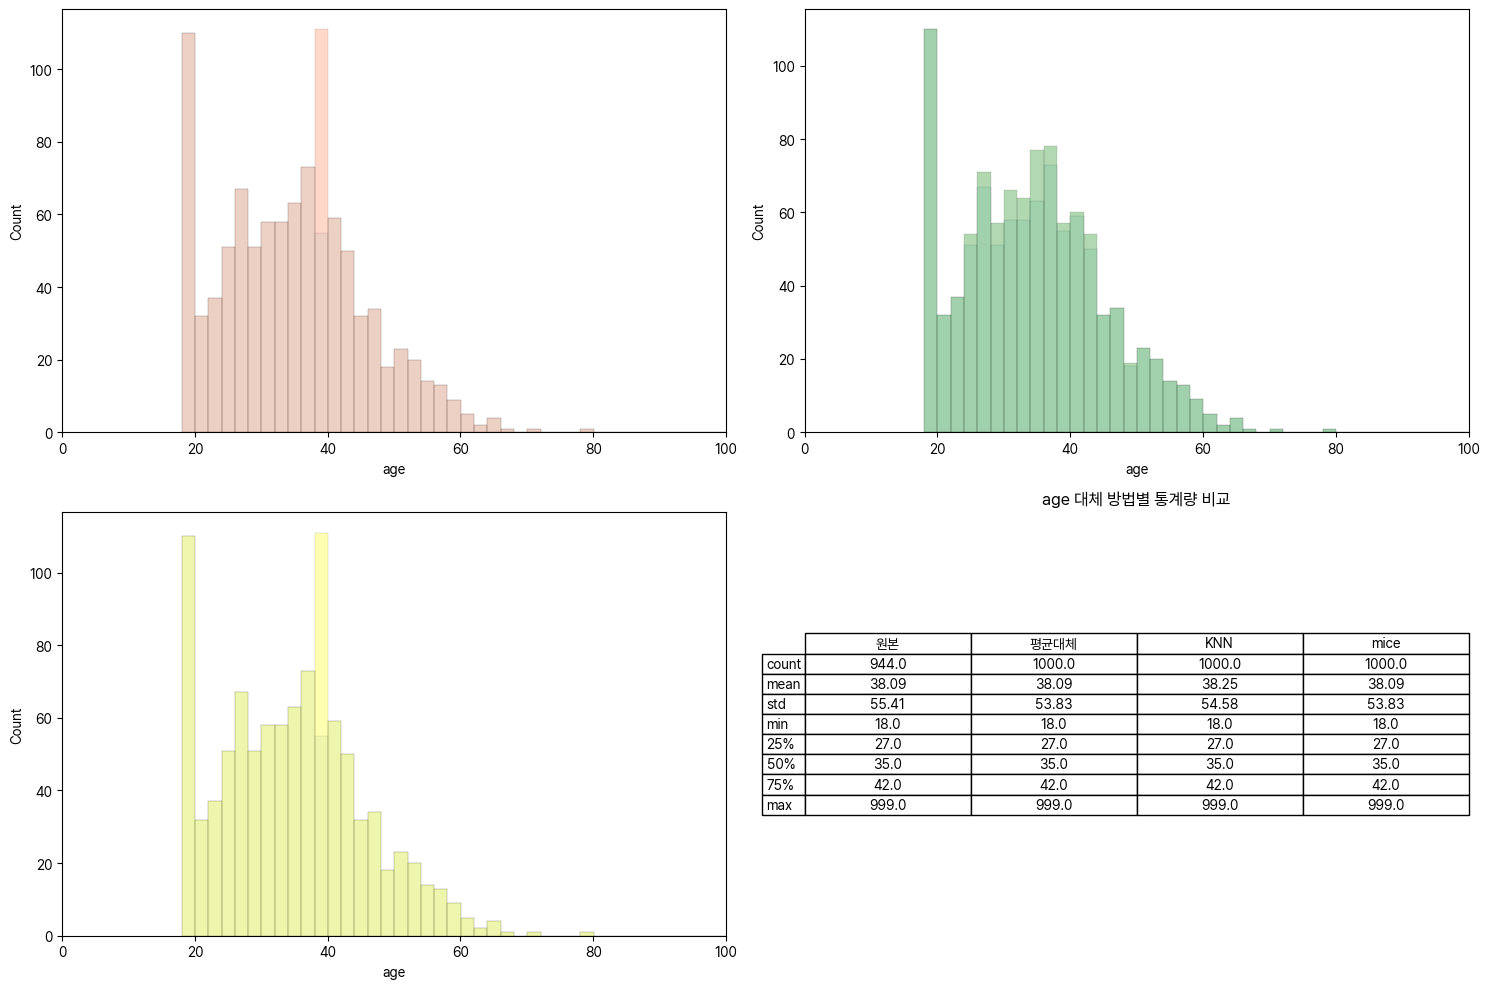

In [136]:
# Impute -> 대체하다.
from pkg_resources import find_eggs_in_zip
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 숫자형 컬럼들
numeric_cols = ['age', 'total_purchases', 'avg_order_value',
       'days_since_last_purchase', 'satisfaction_score']
# ecommerce.select_dtypes(include='number').columns
df_numeric = ecommerce[numeric_cols]
print('원본 데이터 결측률')
for col in numeric_cols:
    missing_rate = df_numeric[col].isnull().mean()
    if missing_rate:
        print(f' {col}: {missing_rate: .2%}')

# 1. 컬럼별 결측치 평균값으로 대체
imputer_mean = SimpleImputer(strategy='mean')
df_mean = df_numeric.copy()
df_mean[numeric_cols] = imputer_mean.fit_transform(df_numeric[numeric_cols])    # 이렇게 하면 평균으로 알아서 채워줌

#(여기부터 고오오오오급)
# 2. KNN 대체
# K-Nearest Neighbors: 
imputer_knn = KNNImputer(n_neighbors=5)
df_knn = df_numeric.copy()
df_knn[numeric_cols] = imputer_knn.fit_transform(df_numeric[numeric_cols])  

# 2. mice 대체
# Multiple Imputation by Chained Equations: 결측이 있는 변수를 다른 변수를 이용해 `회귀`모델 예측
# 변수간 상관관계가 약한경우, 평균으로 도달.
imputer_mice = IterativeImputer(random_state=42, max_iter=10)
df_mice = df_numeric.copy()
df_mice[numeric_cols] = imputer_mice.fit_transform(df_numeric[numeric_cols]) 

# display(df_mean)
# display(df_knn)
# display(df_mice)

# 대체 결과 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# age 변수 대체 결과
variable = 'age'
if df_numeric[variable].isnull().sum():
    x_min, x_max = 0, 100
    sns.histplot(df_numeric[variable], binwidth=2, kde=False, ax=a1, alpha=0.3, label='원본', color='lightblue')
    sns.histplot(df_mean[variable], binwidth=2, kde=False, ax=a1, alpha=0.3, label='원본', color='coral')
    
    a1.set_xlim(x_min, x_max)

    sns.histplot(df_numeric[variable], binwidth=2, kde=False, ax=a2, alpha=0.3, label='원본', color='lightblue')
    sns.histplot(df_knn[variable], binwidth=2, kde=False, ax=a2, alpha=0.3, label='원본', color='green')
    a2.set_xlim(x_min, x_max)

    sns.histplot(df_numeric[variable], binwidth=2, kde=False, ax=a3, alpha=0.3, label='원본', color='lightblue')
    sns.histplot(df_mice[variable], binwidth=2, kde=False, ax=a3, alpha=0.3, label='원본', color='yellow')
    a3.set_xlim(x_min, x_max)

# 대체 전후 통계량 비교
comparison_stats = pd.DataFrame({
    '원본': df_numeric[variable].describe(),
    '평균대체': df_mean[variable].describe(),
    'KNN': df_knn[variable].describe(),
    'mice': df_mice[variable].describe()
}).round(2)

# 텍스트로 통계 비교 표시
a4.axis('off')
a4.table(
    cellText=comparison_stats.values,
    rowLabels=comparison_stats.index,
    colLabels=comparison_stats.columns,
    cellLoc='center',
    loc='center'
)
a4.set_title(f'{variable} 대체 방법별 통계량 비교')

plt.tight_layout()
plt.show()

## 대체 품질 평가

In [165]:
print('=== 대체 품질 평가 ===')
evaluation_results = []

original_df = df_numeric
imputed_dfs = df_mean, df_knn, df_mice
method_names = ['평균대체', 'KNN대체', 'MICE대체']

# 위 1행과 2행을 튜플로 묶음.(싱기방기))
list(zip(method_names, imputed_dfs))

for method, imputed_df in zip(method_names, imputed_dfs):
    for col in ['age', 'satisfaction_score']:
        if original_df[col].isnull().sum():
            original_stats = original_df[col].dropna().describe()
            imputed_stats = imputed_df[col].describe()
            # 평균 차이(%)
            mean_diff = abs(original_stats['mean'] - imputed_stats['mean']) / original_stats['mean'] * 100
            # 표준편(%)) 차이
            std_diff = abs(original_stats['std'] - imputed_stats['std']) / original_stats['std'] * 100
            evaluation_results.append({
                '방법': method,
                '변수': col,
                '평균차이(%)': mean_diff,
                '표준편차차이(%)': std_diff
            })
    
    
    # 2. 상관관계 보존 평가
    # age <-> avg_order_value(지금은 임의 선정, 원래는 검증을 통해서 상관관계가 있는지 봐야함)
    original_corr = original_df[['age', 'avg_order_value']].corr().iloc[0, 1]  # 얘는 결측치 포함
    # original_comp_corr = original_df[['age', 'avg_order_value']].dropna().corr().iloc[0, 1]  # 얘는 결측치 삭제
    imputed_corr = imputed_df[['age', 'avg_order_value']].dropna().corr().iloc[0, 1]    # 얘는 결측치 메움(3가지 방식으로)
    
    # 상관관계 유지 정도
    # corr_preservation = abs(original_comp_corr - imputed_corr) / abs(original_comp_corr) * 100 # 역사속으로 사라지세요.
    og_corr_preservation = abs(original_corr - imputed_corr) / abs(original_corr) * 100

    evaluation_results.append({
        '방법': method,
        '변수': 'Age-구매액 상관관계',
        '원본상관계수': original_corr,
        # '삭제상관계수': original_comp_corr,
        '대체상관계수': imputed_corr,
        '상관계수보존도(%)': 100 - og_corr_preservation,
    })

    


eval_df = pd.DataFrame(evaluation_results)


print('1. 분포 보존 성능')
dist_eval = eval_df[eval_df['변수'].isin(('age', 'satisfaction_score'))]
print(dist_eval[[
    '방법',	'변수',	'평균차이(%)',	'표준편차차이(%)'
]].to_string(index=False))

print('\n2. 상관관계 보존성능')
corr_eval = eval_df[eval_df['변수'].isin(('Age-구매액 상관관계', 'satisfaction_score-구매액 상관관계'))]
for _, row in corr_eval.iterrows():
    print(f'{row['방법']}: 보존도 {row['상관계수보존도(%)']:.1f}%')
    print(f'(원본: {row['원본상관계수']:.3f} -> 대체후: {row['대체상관계수']:.3f})')



=== 대체 품질 평가 ===
1. 분포 보존 성능
    방법                 변수      평균차이(%)  표준편차차이(%)
  평균대체                age 1.865429e-14   2.843222
  평균대체 satisfaction_score 0.000000e+00   3.359743
 KNN대체                age 4.283472e-01   1.495421
 KNN대체 satisfaction_score 2.062418e-01   2.573274
MICE대체                age 8.844091e-04   2.843222
MICE대체 satisfaction_score 1.262428e-02   3.351658

2. 상관관계 보존성능
평균대체: 보존도 94.9%
(원본: -0.000 -> 대체후: -0.000)
KNN대체: 보존도 -550.6%
(원본: -0.000 -> 대체후: -0.003)
MICE대체: 보존도 98.0%
(원본: -0.000 -> 대체후: -0.000)
